In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [90]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2.4.1+cu124


device(type='cuda')

Helper class to prepare tensor dataset

In [91]:
class setData(Dataset):
    def __init__(self, directory, transform):
        self.data = datasets.ImageFolder(root=directory, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

Preparing data

In [92]:
train_path = 'train'
val_path = 'valid'
test_path = 'test'

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_dataset = setData(train_path, transform)
test_dataset = setData(test_path, transform)
val_dataset = setData(val_path, transform)
final_train_dataset = ConcatDataset([train_dataset, test_dataset])
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)
final_train_data = DataLoader(final_train_dataset, batch_size=32, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=32, shuffle=False)


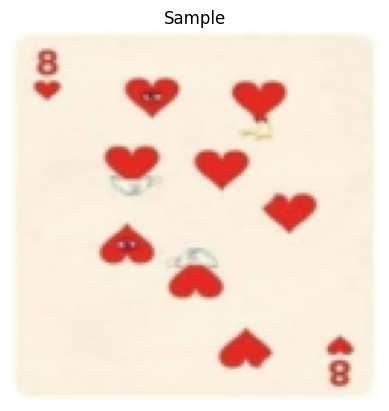

In [93]:
images, labels = next(iter(train_data))
image = np.transpose(images[1].detach(), (1,2,0))
plt.figure()
plt.title('Sample')
plt.axis('off')
plt.imshow(image)

Defining Model

In [94]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8,
                      kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            #nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32,
                      stride=1, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            #nn.Dropout(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      stride=1, kernel_size=5, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            #nn.Dropout(0.2)
        )
        self.out = nn.Linear(576, 53)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


In [95]:
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
criterion = nn.CrossEntropyLoss()
epochs = 100
train_loss, test_loss, train_acc, test_acc = [], [], [], []

Training phase

In [96]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for X, y in tqdm(train_data, desc=f'Epoch: {epoch+1} / {epochs}', leave=False):
        X = X.to(device)
        y = y.to(device)
        ypred = model(X)
        loss = criterion(ypred, y)
        preds = torch.max(ypred, dim=1)[1]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X.shape[0]
        running_acc += (y == preds).sum().item()
    acc = (running_acc / train_dataset.__len__()) * 100
    train_acc.append(acc)
    train_loss.append(running_loss)
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for X, y in tqdm(test_data, desc='Testing', leave=False):
            X = X.to(device)
            y = y.to(device)
            ypred = model(X)
            preds = torch.max(ypred, dim=1)[1]
            running_acc += (y == preds).sum().item()
            loss = criterion(ypred, y)
            running_loss += loss.item() * X.shape[0]
        test_loss.append(running_loss)
        acc = (running_acc / test_dataset.__len__()) * 100
        test_acc.append(acc)
    scheduler.step(running_loss)
    print(f'Epoch: {epoch+1} Train Accuracy: {train_acc[-1]} Test Accuracy: {test_acc[-1]} Train Loss: {train_loss[-1]} Test Loss: {test_loss[-1]}')

Epoch: 1 Train Accuracy: 32.05666316894019 Test Accuracy: 47.924528301886795 Train Loss: 19335.839864730835 Test Loss: 490.287837266922


Epoch: 2 Train Accuracy: 56.87303252885625 Test Accuracy: 68.67924528301886 Train Loss: 12866.507509231567 Test Loss: 348.68733620643616


Epoch: 3 Train Accuracy: 64.84784889821617 Test Accuracy: 69.43396226415094 Train Loss: 10628.880793094635 Test Loss: 309.3059468269348


Epoch: 4 Train Accuracy: 68.90083945435467 Test Accuracy: 71.32075471698113 Train Loss: 9343.299006462097 Test Loss: 304.59465742111206


Epoch: 5 Train Accuracy: 72.87513116474291 Test Accuracy: 72.45283018867924 Train Loss: 8252.8748960495 Test Loss: 276.11176013946533


Epoch: 6 Train Accuracy: 75.7476390346275 Test Accuracy: 77.73584905660378 Train Loss: 7467.755171775818 Test Loss: 238.79163026809692


Epoch: 7 Train Accuracy: 78.35781741867785 Test Accuracy: 74.71698113207546 Train Loss: 6721.273540496826 Test Loss: 257.6978237628937


Epoch: 8 Train Accuracy: 80.90241343126966 Test Accuracy: 80.75471698113208 Train Loss: 6035.749649047852 Test Loss: 202.67326509952545


Epoch: 9 Train Accuracy: 82.63378803777545 Test Accuracy: 78.8679245283019 Train Loss: 5520.209210395813 Test Loss: 230.37733483314514


Epoch: 10 Train Accuracy: 85.099685204617 Test Accuracy: 81.13207547169812 Train Loss: 4891.456337928772 Test Loss: 189.9480104446411


Epoch: 11 Train Accuracy: 86.01783840503673 Test Accuracy: 81.50943396226415 Train Loss: 4584.111426830292 Test Loss: 177.51301419734955


Epoch: 12 Train Accuracy: 87.89349422875131 Test Accuracy: 83.01886792452831 Train Loss: 4172.292186975479 Test Loss: 165.36768460273743


Epoch: 13 Train Accuracy: 88.49685204616999 Test Accuracy: 82.26415094339623 Train Loss: 3891.1478157043457 Test Loss: 169.1988296508789


Epoch: 14 Train Accuracy: 89.33630640083945 Test Accuracy: 84.90566037735849 Train Loss: 3678.503439426422 Test Loss: 136.48935747146606


Epoch: 15 Train Accuracy: 90.56925498426023 Test Accuracy: 85.66037735849056 Train Loss: 3384.4510250091553 Test Loss: 146.0815325975418


Epoch: 16 Train Accuracy: 91.52675760755508 Test Accuracy: 85.28301886792453 Train Loss: 3195.778944015503 Test Loss: 129.9525626897812


Epoch: 17 Train Accuracy: 91.67103882476391 Test Accuracy: 87.16981132075472 Train Loss: 3067.9576392173767 Test Loss: 125.75764620304108


Epoch: 18 Train Accuracy: 92.02518363064009 Test Accuracy: 83.77358490566039 Train Loss: 2977.698173522949 Test Loss: 160.1691014766693


Epoch: 19 Train Accuracy: 92.48426023084994 Test Accuracy: 91.32075471698113 Train Loss: 2870.097484588623 Test Loss: 111.49367892742157


Epoch: 20 Train Accuracy: 93.04826862539349 Test Accuracy: 88.30188679245283 Train Loss: 2668.4922347068787 Test Loss: 118.77750623226166


Epoch: 21 Train Accuracy: 93.67785939139559 Test Accuracy: 90.56603773584906 Train Loss: 2549.5176944732666 Test Loss: 115.36498260498047


Epoch: 22 Train Accuracy: 93.9401888772298 Test Accuracy: 88.67924528301887 Train Loss: 2551.5578187704086 Test Loss: 106.31998383998871


Epoch: 23 Train Accuracy: 93.07450157397692 Test Accuracy: 88.30188679245283 Train Loss: 2554.7209012508392 Test Loss: 132.22312557697296


Epoch: 24 Train Accuracy: 93.91395592864637 Test Accuracy: 89.05660377358491 Train Loss: 2422.394161462784 Test Loss: 124.36410093307495


Epoch: 25 Train Accuracy: 94.35991605456454 Test Accuracy: 89.05660377358491 Train Loss: 2374.4975712299347 Test Loss: 103.15334737300873


Epoch: 26 Train Accuracy: 93.95330535152151 Test Accuracy: 88.67924528301887 Train Loss: 2377.7581026554108 Test Loss: 120.16980874538422


Epoch: 27 Train Accuracy: 94.46484784889822 Test Accuracy: 90.18867924528303 Train Loss: 2313.9142541885376 Test Loss: 101.97688031196594


Epoch: 28 Train Accuracy: 94.01888772298005 Test Accuracy: 89.81132075471699 Train Loss: 2372.001809835434 Test Loss: 130.41548264026642


Epoch: 29 Train Accuracy: 94.45173137460651 Test Accuracy: 90.18867924528303 Train Loss: 2274.2578461170197 Test Loss: 99.50940239429474


Epoch: 30 Train Accuracy: 94.53043022035676 Test Accuracy: 90.18867924528303 Train Loss: 2229.784209251404 Test Loss: 112.77547109127045


Epoch: 31 Train Accuracy: 94.41238195173138 Test Accuracy: 88.30188679245283 Train Loss: 2212.177842736244 Test Loss: 125.42393910884857


Epoch: 32 Train Accuracy: 94.72717733473243 Test Accuracy: 90.9433962264151 Train Loss: 2138.005003064871 Test Loss: 110.87772089242935


Epoch: 33 Train Accuracy: 95.16002098635886 Test Accuracy: 89.81132075471699 Train Loss: 2106.800950050354 Test Loss: 96.50506091117859


Epoch: 34 Train Accuracy: 94.700944386149 Test Accuracy: 88.30188679245283 Train Loss: 2137.926225423813 Test Loss: 113.7927873134613


Epoch: 35 Train Accuracy: 94.55666316894019 Test Accuracy: 90.56603773584906 Train Loss: 2191.176193714142 Test Loss: 98.16564917564392


Epoch: 36 Train Accuracy: 95.23871983210913 Test Accuracy: 81.50943396226415 Train Loss: 1998.272182226181 Test Loss: 196.92911994457245


Epoch: 37 Train Accuracy: 94.83210912906611 Test Accuracy: 87.9245283018868 Train Loss: 2086.1053442955017 Test Loss: 101.96170043945312


Epoch: 38 Train Accuracy: 95.0682056663169 Test Accuracy: 91.69811320754717 Train Loss: 2053.8257082104683 Test Loss: 94.72631454467773


Epoch: 39 Train Accuracy: 94.88457502623295 Test Accuracy: 89.81132075471699 Train Loss: 2054.2061712145805 Test Loss: 126.09226262569427


Epoch: 40 Train Accuracy: 95.50104931794333 Test Accuracy: 92.0754716981132 Train Loss: 1934.9518229961395 Test Loss: 86.72424006462097


Epoch: 41 Train Accuracy: 95.40923399790137 Test Accuracy: 89.05660377358491 Train Loss: 1931.794192790985 Test Loss: 114.27936136722565


Epoch: 42 Train Accuracy: 95.39611752360966 Test Accuracy: 88.67924528301887 Train Loss: 1926.9431842565536 Test Loss: 114.5910679101944


Epoch: 43 Train Accuracy: 95.23871983210913 Test Accuracy: 88.67924528301887 Train Loss: 1928.8088891506195 Test Loss: 118.58535635471344


Epoch: 44 Train Accuracy: 95.25183630640083 Test Accuracy: 90.56603773584906 Train Loss: 1967.1361664533615 Test Loss: 102.09564435482025


Epoch: 45 Train Accuracy: 95.47481636935991 Test Accuracy: 92.0754716981132 Train Loss: 1862.4608409404755 Test Loss: 99.45590686798096


Epoch: 46 Train Accuracy: 95.56663168940189 Test Accuracy: 87.54716981132076 Train Loss: 1899.9950882196426 Test Loss: 119.77808237075806


Epoch: 47 Train Accuracy: 98.62277019937041 Test Accuracy: 93.9622641509434 Train Loss: 1101.997542887926 Test Loss: 75.90694046020508


Epoch: 48 Train Accuracy: 99.19989506820566 Test Accuracy: 94.33962264150944 Train Loss: 889.2623066604137 Test Loss: 79.05521404743195


Epoch: 49 Train Accuracy: 99.38352570828961 Test Accuracy: 93.9622641509434 Train Loss: 821.9863143563271 Test Loss: 77.42988562583923


Epoch: 50 Train Accuracy: 99.46222455403986 Test Accuracy: 93.20754716981132 Train Loss: 781.7800229787827 Test Loss: 81.10098683834076


Epoch: 51 Train Accuracy: 99.40975865687304 Test Accuracy: 92.45283018867924 Train Loss: 775.8431460857391 Test Loss: 81.21036517620087


Epoch: 52 Train Accuracy: 99.55403987408185 Test Accuracy: 93.20754716981132 Train Loss: 758.9430642127991 Test Loss: 79.65303301811218


Epoch: 53 Train Accuracy: 99.55403987408185 Test Accuracy: 93.20754716981132 Train Loss: 759.5979624986649 Test Loss: 83.37069463729858


Epoch: 54 Train Accuracy: 99.65897166841553 Test Accuracy: 92.45283018867924 Train Loss: 704.4697950780392 Test Loss: 81.55331492424011


Epoch: 55 Train Accuracy: 99.68520461699894 Test Accuracy: 92.45283018867924 Train Loss: 704.2194775938988 Test Loss: 80.746307015419


Epoch: 56 Train Accuracy: 99.72455403987408 Test Accuracy: 92.83018867924528 Train Loss: 693.575646519661 Test Loss: 81.00461566448212


Epoch: 57 Train Accuracy: 99.69832109129067 Test Accuracy: 92.45283018867924 Train Loss: 700.4526362717152 Test Loss: 82.7521060705185


Epoch: 58 Train Accuracy: 99.65897166841553 Test Accuracy: 92.83018867924528 Train Loss: 687.8281280398369 Test Loss: 81.25679337978363


Epoch: 59 Train Accuracy: 99.71143756558237 Test Accuracy: 92.83018867924528 Train Loss: 695.6435050368309 Test Loss: 81.79037165641785


Epoch: 60 Train Accuracy: 99.67208814270724 Test Accuracy: 93.58490566037736 Train Loss: 692.6969321370125 Test Loss: 79.54077804088593


Epoch: 61 Train Accuracy: 99.69832109129067 Test Accuracy: 92.83018867924528 Train Loss: 692.3989876508713 Test Loss: 82.001509308815


Epoch: 62 Train Accuracy: 99.68520461699894 Test Accuracy: 92.45283018867924 Train Loss: 687.557292342186 Test Loss: 81.393523812294


Epoch: 63 Train Accuracy: 99.71143756558237 Test Accuracy: 93.20754716981132 Train Loss: 690.2516691088676 Test Loss: 81.59194147586823


Epoch: 64 Train Accuracy: 99.67208814270724 Test Accuracy: 92.45283018867924 Train Loss: 689.3496243953705 Test Loss: 82.09823167324066


Epoch: 65 Train Accuracy: 99.69832109129067 Test Accuracy: 92.45283018867924 Train Loss: 689.0746945142746 Test Loss: 81.18912434577942


Epoch: 66 Train Accuracy: 99.68520461699894 Test Accuracy: 93.20754716981132 Train Loss: 681.5039719641209 Test Loss: 81.45700085163116


Epoch: 67 Train Accuracy: 99.69832109129067 Test Accuracy: 92.45283018867924 Train Loss: 681.6627008914948 Test Loss: 81.63854610919952


Epoch: 68 Train Accuracy: 99.68520461699894 Test Accuracy: 93.58490566037736 Train Loss: 691.6712123155594 Test Loss: 80.35345721244812


Epoch: 69 Train Accuracy: 99.7507869884575 Test Accuracy: 92.83018867924528 Train Loss: 683.4238927066326 Test Loss: 82.10825109481812


Epoch: 70 Train Accuracy: 99.68520461699894 Test Accuracy: 92.0754716981132 Train Loss: 692.5923650860786 Test Loss: 82.23722183704376


Epoch: 71 Train Accuracy: 99.7507869884575 Test Accuracy: 92.83018867924528 Train Loss: 684.8952560424805 Test Loss: 82.1611133813858


Epoch: 72 Train Accuracy: 99.64585519412383 Test Accuracy: 92.0754716981132 Train Loss: 696.482590764761 Test Loss: 82.273113489151


Epoch: 73 Train Accuracy: 99.68520461699894 Test Accuracy: 93.20754716981132 Train Loss: 686.6716339588165 Test Loss: 81.06511163711548


Epoch: 74 Train Accuracy: 99.69832109129067 Test Accuracy: 92.83018867924528 Train Loss: 690.8210147917271 Test Loss: 81.63690340518951


Epoch: 75 Train Accuracy: 99.7507869884575 Test Accuracy: 93.20754716981132 Train Loss: 685.7331774830818 Test Loss: 80.48992121219635


Epoch: 76 Train Accuracy: 99.67208814270724 Test Accuracy: 93.20754716981132 Train Loss: 685.5599135160446 Test Loss: 81.34311032295227


Epoch: 77 Train Accuracy: 99.72455403987408 Test Accuracy: 92.45283018867924 Train Loss: 693.9285724759102 Test Loss: 83.1545991897583


Epoch: 78 Train Accuracy: 99.72455403987408 Test Accuracy: 92.45283018867924 Train Loss: 689.9831261634827 Test Loss: 82.85531508922577


Epoch: 79 Train Accuracy: 99.7507869884575 Test Accuracy: 92.83018867924528 Train Loss: 679.7461671233177 Test Loss: 81.64974176883698


Epoch: 80 Train Accuracy: 99.68520461699894 Test Accuracy: 92.0754716981132 Train Loss: 689.0409074425697 Test Loss: 82.14187574386597


Epoch: 81 Train Accuracy: 99.72455403987408 Test Accuracy: 93.20754716981132 Train Loss: 691.540635228157 Test Loss: 80.94320130348206


Epoch: 82 Train Accuracy: 99.69832109129067 Test Accuracy: 92.45283018867924 Train Loss: 684.6934707760811 Test Loss: 81.94132697582245


Epoch: 83 Train Accuracy: 99.68520461699894 Test Accuracy: 92.0754716981132 Train Loss: 691.0324951410294 Test Loss: 81.8041375875473


Epoch: 84 Train Accuracy: 99.72455403987408 Test Accuracy: 93.20754716981132 Train Loss: 684.2225752174854 Test Loss: 80.94557118415833


Epoch: 85 Train Accuracy: 99.67208814270724 Test Accuracy: 92.83018867924528 Train Loss: 688.6925255060196 Test Loss: 81.63309836387634


Epoch: 86 Train Accuracy: 99.73767051416579 Test Accuracy: 93.20754716981132 Train Loss: 693.7459256350994 Test Loss: 81.15005993843079


Epoch: 87 Train Accuracy: 99.69832109129067 Test Accuracy: 93.58490566037736 Train Loss: 690.1184009760618 Test Loss: 80.66010534763336


Epoch: 88 Train Accuracy: 99.69832109129067 Test Accuracy: 92.83018867924528 Train Loss: 687.8600093126297 Test Loss: 79.79219126701355


Epoch: 89 Train Accuracy: 99.67208814270724 Test Accuracy: 92.45283018867924 Train Loss: 682.5852916836739 Test Loss: 81.83808636665344


Epoch: 90 Train Accuracy: 99.67208814270724 Test Accuracy: 91.69811320754717 Train Loss: 684.6086831688881 Test Loss: 80.06430149078369


Epoch: 91 Train Accuracy: 99.69832109129067 Test Accuracy: 92.45283018867924 Train Loss: 689.4140448570251 Test Loss: 82.87172949314117


Epoch: 92 Train Accuracy: 99.68520461699894 Test Accuracy: 93.20754716981132 Train Loss: 685.8858497142792 Test Loss: 81.4556314945221


Epoch: 93 Train Accuracy: 99.71143756558237 Test Accuracy: 93.20754716981132 Train Loss: 694.6938591599464 Test Loss: 83.62999176979065


Epoch: 94 Train Accuracy: 99.71143756558237 Test Accuracy: 92.45283018867924 Train Loss: 688.0102573633194 Test Loss: 81.98880195617676


Epoch: 95 Train Accuracy: 99.71143756558237 Test Accuracy: 92.45283018867924 Train Loss: 695.4532803297043 Test Loss: 82.53095555305481


Epoch: 96 Train Accuracy: 99.68520461699894 Test Accuracy: 93.20754716981132 Train Loss: 685.7342422604561 Test Loss: 81.08517515659332


Epoch: 97 Train Accuracy: 99.69832109129067 Test Accuracy: 93.20754716981132 Train Loss: 691.4320477247238 Test Loss: 80.35442924499512


Epoch: 98 Train Accuracy: 99.64585519412383 Test Accuracy: 93.58490566037736 Train Loss: 696.5869225859642 Test Loss: 79.45015895366669


Epoch: 99 Train Accuracy: 99.68520461699894 Test Accuracy: 93.20754716981132 Train Loss: 684.8190799951553 Test Loss: 81.3325572013855


Epoch: 100 Train Accuracy: 99.67208814270724 Test Accuracy: 92.83018867924528 Train Loss: 703.0311107635498 Test Loss: 82.32458078861237


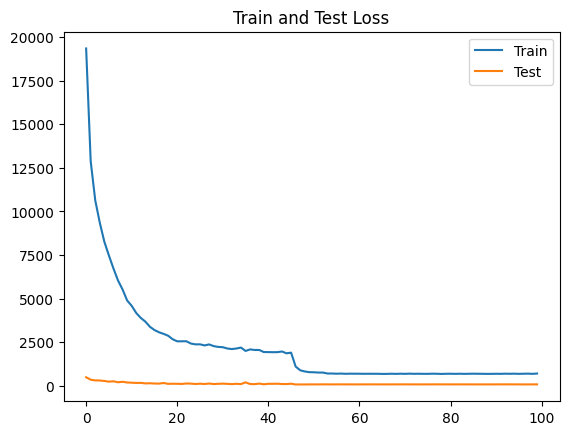

In [97]:
plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), test_loss, label='Test')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

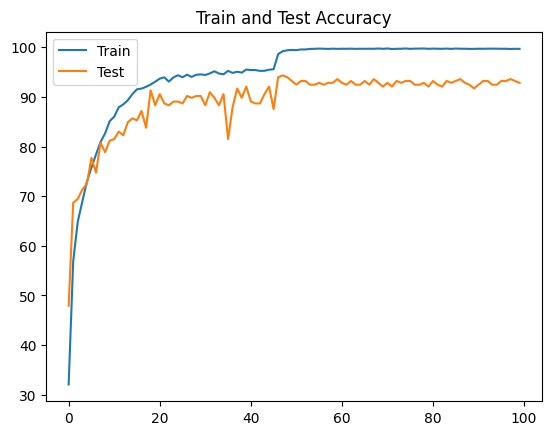

In [98]:
plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), test_acc, label='Test')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()

Training the model on Train + Test to perform validation

In [99]:
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
criterion = nn.CrossEntropyLoss()
epochs = 100
train_loss, test_loss, train_acc, test_acc = [], [], [], []

In [100]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for X, y in tqdm(final_train_data, desc=f'Epoch: {epoch+1} / {epochs}', leave=False):
        X = X.to(device)
        y = y.to(device)
        ypred = model(X)
        loss = criterion(ypred, y)
        preds = torch.max(ypred, dim=1)[1]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X.shape[0]
        running_acc += (y == preds).sum().item()
    acc = (running_acc / final_train_dataset.__len__()) * 100
    train_acc.append(acc)
    train_loss.append(running_loss)
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for X, y in tqdm(val_data, desc='Testing', leave=False):
            X = X.to(device)
            y = y.to(device)
            ypred = model(X)
            preds = torch.max(ypred, dim=1)[1]
            running_acc += (y == preds).sum().item()
            loss = criterion(ypred, y)
            running_loss += loss.item() * X.shape[0]
        test_loss.append(running_loss)
        acc = (running_acc / val_dataset.__len__()) * 100
        test_acc.append(acc)

    scheduler.step(running_loss)
    print(f'Epoch: {epoch+1} Train Accuracy: {train_acc[-1]} Test Accuracy: {test_acc[-1]} Train Loss: {train_loss[-1]} Test Loss: {test_loss[-1]}')

Epoch: 1 Train Accuracy: 31.258714665990624 Test Accuracy: 61.886792452830186 Train Loss: 19940.98810005188 Test Loss: 414.42786693573


Epoch: 2 Train Accuracy: 56.04005577386234 Test Accuracy: 67.16981132075472 Train Loss: 13508.508032679558 Test Loss: 333.8747329711914


Epoch: 3 Train Accuracy: 65.53428824946127 Test Accuracy: 73.9622641509434 Train Loss: 10842.995087623596 Test Loss: 287.40988409519196


Epoch: 4 Train Accuracy: 70.2497147927494 Test Accuracy: 80.75471698113208 Train Loss: 9422.217020630836 Test Loss: 222.43757259845734


Epoch: 5 Train Accuracy: 73.67220179997464 Test Accuracy: 76.22641509433963 Train Loss: 8301.011524260044 Test Loss: 237.5438027381897


Epoch: 6 Train Accuracy: 76.89187476232729 Test Accuracy: 80.75471698113208 Train Loss: 7418.270654916763 Test Loss: 214.26452958583832


Epoch: 7 Train Accuracy: 79.6678920015211 Test Accuracy: 84.90566037735849 Train Loss: 6594.000903606415 Test Loss: 158.7704255580902


Epoch: 8 Train Accuracy: 82.25377107364686 Test Accuracy: 84.52830188679246 Train Loss: 5851.732361257076 Test Loss: 154.45794308185577


Epoch: 9 Train Accuracy: 84.0410698440867 Test Accuracy: 85.28301886792453 Train Loss: 5401.134378194809 Test Loss: 160.96120715141296


Epoch: 10 Train Accuracy: 85.58752693624034 Test Accuracy: 87.54716981132076 Train Loss: 4846.5615720152855 Test Loss: 143.77267080545425


Epoch: 11 Train Accuracy: 86.7156800608442 Test Accuracy: 88.30188679245283 Train Loss: 4456.434066772461 Test Loss: 141.42955175042152


Epoch: 12 Train Accuracy: 88.47762707567499 Test Accuracy: 86.0377358490566 Train Loss: 4095.2349582910538 Test Loss: 132.90407966077328


Epoch: 13 Train Accuracy: 89.56775256686525 Test Accuracy: 89.05660377358491 Train Loss: 3757.6711649894714 Test Loss: 116.21464112401009


Epoch: 14 Train Accuracy: 89.9480289010014 Test Accuracy: 86.0377358490566 Train Loss: 3633.2615682780743 Test Loss: 140.53558057546616


Epoch: 15 Train Accuracy: 91.27899607047787 Test Accuracy: 90.18867924528303 Train Loss: 3337.8546142578125 Test Loss: 100.46487057209015


Epoch: 16 Train Accuracy: 92.06490049435924 Test Accuracy: 87.16981132075472 Train Loss: 3114.9243324548006 Test Loss: 129.76314336061478


Epoch: 17 Train Accuracy: 91.49448599315502 Test Accuracy: 89.43396226415095 Train Loss: 3162.2079463899136 Test Loss: 107.2930271178484


Epoch: 18 Train Accuracy: 92.50855621751806 Test Accuracy: 90.9433962264151 Train Loss: 2965.9675796628 Test Loss: 85.43276450037956


Epoch: 19 Train Accuracy: 93.01559132969957 Test Accuracy: 87.54716981132076 Train Loss: 2823.48500084877 Test Loss: 110.62461073696613


Epoch: 20 Train Accuracy: 92.8254531626315 Test Accuracy: 92.83018867924528 Train Loss: 2789.6399191766977 Test Loss: 106.15384593605995


Epoch: 21 Train Accuracy: 93.10432247433134 Test Accuracy: 91.69811320754717 Train Loss: 2753.510208070278 Test Loss: 87.75672620534897


Epoch: 22 Train Accuracy: 93.80149575358094 Test Accuracy: 89.81132075471699 Train Loss: 2621.8873684108257 Test Loss: 91.87310602515936


Epoch: 23 Train Accuracy: 93.02826720750413 Test Accuracy: 87.54716981132076 Train Loss: 2692.6847581267357 Test Loss: 98.15128922462463


Epoch: 24 Train Accuracy: 93.87755102040816 Test Accuracy: 90.9433962264151 Train Loss: 2548.486137151718 Test Loss: 91.9533474445343


Epoch: 25 Train Accuracy: 97.42679680567879 Test Accuracy: 93.58490566037736 Train Loss: 1618.271638840437 Test Loss: 60.97727359831333


Epoch: 26 Train Accuracy: 98.66903283052352 Test Accuracy: 93.20754716981132 Train Loss: 1319.5064020901918 Test Loss: 62.28159164637327


Epoch: 27 Train Accuracy: 98.85917099759158 Test Accuracy: 93.20754716981132 Train Loss: 1222.9056665301323 Test Loss: 60.1142201051116


Epoch: 28 Train Accuracy: 99.12536443148689 Test Accuracy: 93.58490566037736 Train Loss: 1169.1055941581726 Test Loss: 60.85012046247721


Epoch: 29 Train Accuracy: 99.15071618709595 Test Accuracy: 93.58490566037736 Train Loss: 1139.020730227232 Test Loss: 60.40204778313637


Epoch: 30 Train Accuracy: 99.20141969831411 Test Accuracy: 94.33962264150944 Train Loss: 1109.3640481829643 Test Loss: 62.24754908680916


Epoch: 31 Train Accuracy: 99.22677145392318 Test Accuracy: 93.20754716981132 Train Loss: 1123.3244743049145 Test Loss: 64.19699468463659


Epoch: 32 Train Accuracy: 99.29015084294588 Test Accuracy: 93.20754716981132 Train Loss: 1119.7003094106913 Test Loss: 65.51956091821194


Epoch: 33 Train Accuracy: 99.39155786538217 Test Accuracy: 93.20754716981132 Train Loss: 1112.8595513403416 Test Loss: 60.53001722693443


Epoch: 34 Train Accuracy: 99.45493725440487 Test Accuracy: 93.20754716981132 Train Loss: 1013.2796848416328 Test Loss: 62.3902352899313


Epoch: 35 Train Accuracy: 99.46761313220941 Test Accuracy: 93.20754716981132 Train Loss: 992.8922737538815 Test Loss: 62.87011718004942


Epoch: 36 Train Accuracy: 99.51831664342757 Test Accuracy: 93.20754716981132 Train Loss: 995.8245996832848 Test Loss: 62.22237550467253


Epoch: 37 Train Accuracy: 99.51831664342757 Test Accuracy: 93.58490566037736 Train Loss: 987.9241232872009 Test Loss: 62.70351965725422


Epoch: 38 Train Accuracy: 99.54366839903663 Test Accuracy: 92.83018867924528 Train Loss: 989.0664768964052 Test Loss: 62.637865878641605


Epoch: 39 Train Accuracy: 99.51831664342757 Test Accuracy: 92.83018867924528 Train Loss: 992.3147023320198 Test Loss: 63.051686987280846


Epoch: 40 Train Accuracy: 99.54366839903663 Test Accuracy: 93.20754716981132 Train Loss: 975.5588228404522 Test Loss: 64.1114559546113


Epoch: 41 Train Accuracy: 99.58169603245025 Test Accuracy: 93.58490566037736 Train Loss: 973.861900895834 Test Loss: 63.29040667414665


Epoch: 42 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 979.2106932923198 Test Loss: 63.17364828288555


Epoch: 43 Train Accuracy: 99.58169603245025 Test Accuracy: 92.83018867924528 Train Loss: 979.5192786157131 Test Loss: 62.6823198646307


Epoch: 44 Train Accuracy: 99.5309925212321 Test Accuracy: 93.20754716981132 Train Loss: 988.5643215477467 Test Loss: 63.15506254136562


Epoch: 45 Train Accuracy: 99.49296488781847 Test Accuracy: 93.20754716981132 Train Loss: 986.6391703039408 Test Loss: 63.286062233150005


Epoch: 46 Train Accuracy: 99.5690201546457 Test Accuracy: 93.58490566037736 Train Loss: 983.0642543099821 Test Loss: 63.65585804730654


Epoch: 47 Train Accuracy: 99.5309925212321 Test Accuracy: 93.58490566037736 Train Loss: 966.8249022290111 Test Loss: 63.72820618748665


Epoch: 48 Train Accuracy: 99.61972366586386 Test Accuracy: 93.58490566037736 Train Loss: 971.7112627997994 Test Loss: 63.66568487137556


Epoch: 49 Train Accuracy: 99.5943719102548 Test Accuracy: 93.58490566037736 Train Loss: 980.9010869115591 Test Loss: 63.64524445682764


Epoch: 50 Train Accuracy: 99.55634427684117 Test Accuracy: 93.58490566037736 Train Loss: 975.5498600304127 Test Loss: 63.946693398058414


Epoch: 51 Train Accuracy: 99.6323995436684 Test Accuracy: 93.20754716981132 Train Loss: 985.3655343651772 Test Loss: 64.09581629186869


Epoch: 52 Train Accuracy: 99.54366839903663 Test Accuracy: 93.20754716981132 Train Loss: 978.4193240478635 Test Loss: 63.49081375449896


Epoch: 53 Train Accuracy: 99.5943719102548 Test Accuracy: 93.58490566037736 Train Loss: 971.0690052956343 Test Loss: 62.70160682499409


Epoch: 54 Train Accuracy: 99.51831664342757 Test Accuracy: 93.58490566037736 Train Loss: 979.1037917435169 Test Loss: 63.986329555511475


Epoch: 55 Train Accuracy: 99.5690201546457 Test Accuracy: 93.20754716981132 Train Loss: 970.942510381341 Test Loss: 63.82024072110653


Epoch: 56 Train Accuracy: 99.54366839903663 Test Accuracy: 93.20754716981132 Train Loss: 977.8636022359133 Test Loss: 63.24012652039528


Epoch: 57 Train Accuracy: 99.55634427684117 Test Accuracy: 93.58490566037736 Train Loss: 977.7529626488686 Test Loss: 64.65367763489485


Epoch: 58 Train Accuracy: 99.5690201546457 Test Accuracy: 93.58490566037736 Train Loss: 976.3374648205936 Test Loss: 63.518794901669025


Epoch: 59 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 980.5485286936164 Test Loss: 64.40117959678173


Epoch: 60 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 974.9163872152567 Test Loss: 64.17720702290535


Epoch: 61 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 977.3087678179145 Test Loss: 63.50373215973377


Epoch: 62 Train Accuracy: 99.50564076562301 Test Accuracy: 93.58490566037736 Train Loss: 982.907334856689 Test Loss: 63.195515014231205


Epoch: 63 Train Accuracy: 99.55634427684117 Test Accuracy: 93.20754716981132 Train Loss: 977.1461934447289 Test Loss: 62.53079763054848


Epoch: 64 Train Accuracy: 99.49296488781847 Test Accuracy: 92.83018867924528 Train Loss: 984.4060565233231 Test Loss: 64.03923841565847


Epoch: 65 Train Accuracy: 99.5309925212321 Test Accuracy: 93.20754716981132 Train Loss: 988.5839485377073 Test Loss: 63.903942205011845


Epoch: 66 Train Accuracy: 99.5690201546457 Test Accuracy: 92.83018867924528 Train Loss: 977.407553806901 Test Loss: 62.67056269943714


Epoch: 67 Train Accuracy: 99.55634427684117 Test Accuracy: 92.83018867924528 Train Loss: 985.2600066289306 Test Loss: 62.683522306382656


Epoch: 68 Train Accuracy: 99.58169603245025 Test Accuracy: 92.83018867924528 Train Loss: 970.1046492382884 Test Loss: 63.31057617813349


Epoch: 69 Train Accuracy: 99.6323995436684 Test Accuracy: 93.58490566037736 Train Loss: 970.4993594065309 Test Loss: 63.66421142220497


Epoch: 70 Train Accuracy: 99.5690201546457 Test Accuracy: 93.20754716981132 Train Loss: 971.2516379952431 Test Loss: 63.081892021000385


Epoch: 71 Train Accuracy: 99.46761313220941 Test Accuracy: 93.58490566037736 Train Loss: 975.7570270001888 Test Loss: 64.23370105028152


Epoch: 72 Train Accuracy: 99.6323995436684 Test Accuracy: 93.58490566037736 Train Loss: 970.995632879436 Test Loss: 64.08855155855417


Epoch: 73 Train Accuracy: 99.5309925212321 Test Accuracy: 93.20754716981132 Train Loss: 977.8345734067261 Test Loss: 63.27101093530655


Epoch: 74 Train Accuracy: 99.55634427684117 Test Accuracy: 93.20754716981132 Train Loss: 980.5842973217368 Test Loss: 63.54874498397112


Epoch: 75 Train Accuracy: 99.58169603245025 Test Accuracy: 93.58490566037736 Train Loss: 976.7473011165857 Test Loss: 64.51312148571014


Epoch: 76 Train Accuracy: 99.5690201546457 Test Accuracy: 93.58490566037736 Train Loss: 969.3728643544018 Test Loss: 63.562520161271095


Epoch: 77 Train Accuracy: 99.5690201546457 Test Accuracy: 93.20754716981132 Train Loss: 986.5297166705132 Test Loss: 64.48224168270826


Epoch: 78 Train Accuracy: 99.5690201546457 Test Accuracy: 92.83018867924528 Train Loss: 979.6295166313648 Test Loss: 63.75080290436745


Epoch: 79 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 965.6989816129208 Test Loss: 62.99468137323856


Epoch: 80 Train Accuracy: 99.55634427684117 Test Accuracy: 92.83018867924528 Train Loss: 980.5419756621122 Test Loss: 63.86259013414383


Epoch: 81 Train Accuracy: 99.54366839903663 Test Accuracy: 93.58490566037736 Train Loss: 970.9952248483896 Test Loss: 64.0207930803299


Epoch: 82 Train Accuracy: 99.5690201546457 Test Accuracy: 92.83018867924528 Train Loss: 978.1921704933047 Test Loss: 63.57185872644186


Epoch: 83 Train Accuracy: 99.5943719102548 Test Accuracy: 93.58490566037736 Train Loss: 971.1529140025377 Test Loss: 63.53360343724489


Epoch: 84 Train Accuracy: 99.58169603245025 Test Accuracy: 93.20754716981132 Train Loss: 979.2357015758753 Test Loss: 62.60101813822985


Epoch: 85 Train Accuracy: 99.64507542147294 Test Accuracy: 93.20754716981132 Train Loss: 977.1520863771439 Test Loss: 63.187413066625595


Epoch: 86 Train Accuracy: 99.51831664342757 Test Accuracy: 92.83018867924528 Train Loss: 977.1093938499689 Test Loss: 62.93514248728752


Epoch: 87 Train Accuracy: 99.58169603245025 Test Accuracy: 93.58490566037736 Train Loss: 965.2412754893303 Test Loss: 63.29061260819435


Epoch: 88 Train Accuracy: 99.61972366586386 Test Accuracy: 93.58490566037736 Train Loss: 974.776455283165 Test Loss: 63.81764130294323


Epoch: 89 Train Accuracy: 99.55634427684117 Test Accuracy: 93.58490566037736 Train Loss: 981.8480751514435 Test Loss: 64.03342801332474


Epoch: 90 Train Accuracy: 99.55634427684117 Test Accuracy: 93.58490566037736 Train Loss: 974.6615365445614 Test Loss: 64.88879612088203


Epoch: 91 Train Accuracy: 99.58169603245025 Test Accuracy: 93.58490566037736 Train Loss: 976.8572795316577 Test Loss: 63.4658999890089


Epoch: 92 Train Accuracy: 99.5309925212321 Test Accuracy: 93.58490566037736 Train Loss: 974.9115172326565 Test Loss: 63.10515635460615


Epoch: 93 Train Accuracy: 99.51831664342757 Test Accuracy: 93.20754716981132 Train Loss: 975.3157022669911 Test Loss: 63.73476280272007


Epoch: 94 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 975.1618805378675 Test Loss: 64.12339875102043


Epoch: 95 Train Accuracy: 99.50564076562301 Test Accuracy: 93.58490566037736 Train Loss: 979.8116148710251 Test Loss: 63.92516712099314


Epoch: 96 Train Accuracy: 99.5690201546457 Test Accuracy: 93.20754716981132 Train Loss: 978.1522404104471 Test Loss: 64.20844951272011


Epoch: 97 Train Accuracy: 99.5690201546457 Test Accuracy: 93.20754716981132 Train Loss: 971.8625021278858 Test Loss: 63.05244114995003


Epoch: 98 Train Accuracy: 99.5943719102548 Test Accuracy: 93.20754716981132 Train Loss: 977.2669202387333 Test Loss: 63.77434220910072


Epoch: 99 Train Accuracy: 99.51831664342757 Test Accuracy: 93.58490566037736 Train Loss: 975.097600903362 Test Loss: 63.66066248714924


Epoch: 100 Train Accuracy: 99.5690201546457 Test Accuracy: 93.20754716981132 Train Loss: 978.300794839859 Test Loss: 63.9296982139349


[19940.98810005188, 13508.508032679558, 10842.995087623596, 9422.217020630836, 8301.011524260044, 7418.270654916763, 6594.000903606415, 5851.732361257076, 5401.134378194809, 4846.5615720152855, 4456.434066772461, 4095.2349582910538, 3757.6711649894714, 3633.2615682780743, 3337.8546142578125, 3114.9243324548006, 3162.2079463899136, 2965.9675796628, 2823.48500084877, 2789.6399191766977, 2753.510208070278, 2621.8873684108257, 2692.6847581267357, 2548.486137151718, 1618.271638840437, 1319.5064020901918, 1222.9056665301323, 1169.1055941581726, 1139.020730227232, 1109.3640481829643, 1123.3244743049145, 1119.7003094106913, 1112.8595513403416, 1013.2796848416328, 992.8922737538815, 995.8245996832848, 987.9241232872009, 989.0664768964052, 992.3147023320198, 975.5588228404522, 973.861900895834, 979.2106932923198, 979.5192786157131, 988.5643215477467, 986.6391703039408, 983.0642543099821, 966.8249022290111, 971.7112627997994, 980.9010869115591, 975.5498600304127, 985.3655343651772, 978.4193240478

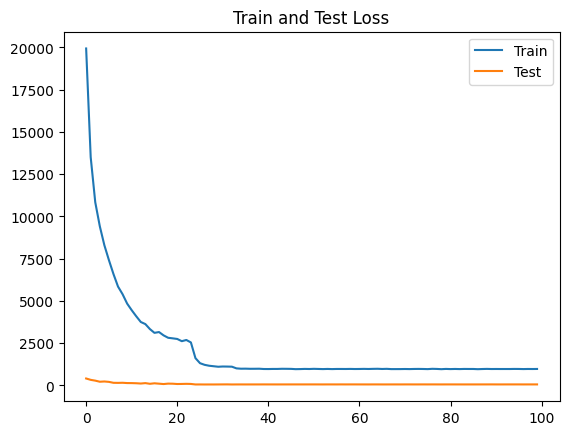

In [101]:
print(train_loss)
plt.figure()
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), test_loss, label='Test')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

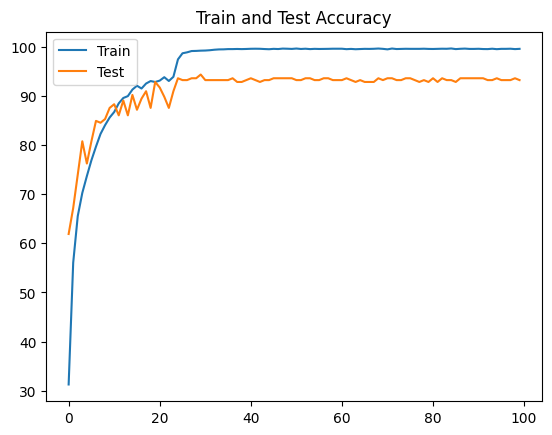

In [102]:
plt.figure()
plt.plot(range(epochs), train_acc, label='Train')
plt.plot(range(epochs), test_acc, label='Test')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()

In [103]:
models = {
    'Model': model.state_dict(),
    'Optimizer': optimizer.state_dict()
}
torch.save(models, 'modelconfig.pth')